We are using the general outline of the machine learning pipeline to structure our project:

1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well-documented report

The first notebook covered steps 1-3, and in this notebook, we will cover 4-6.

### Imports 

We will use the standard data science and machine learning libraries in this project. 

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Read in Data

First let's read in the formatted data from the previous notebook. 

In [3]:
# Read in data into dataframes 
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (8802, 79)
Testing Feature Size:   (3773, 79)
Training Labels Size:   (8802, 1)
Testing Labels Size:    (3773, 1)


In [4]:
train_features.head(12)

,Property Id,2nd Largest Property Use - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Electricity Use - Grid Purchase (kBtu),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Largest Property Use Type - Gross Floor Area (ft²),log_2nd Largest Property Use - Gross Floor Area (ft²),log_Direct GHG Emissions (Metric Tons CO2e),log_Water Intensity (All Water Sources) (gal/ft²),Borough_STATEN IS,Largest Property Use Type_Adult Education,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Data Center,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Fire Station,...,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Police Station,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Prison/Incarceration,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Stadium (Open),Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Transportation Terminal/Station,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wastewater Treatment Plant,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility,Largest Property Use Type_Zoo
0,3121317,25000.0,1928,1,100,73.6,4.9,0.0,2049860.5,NaN,40.776112,-73.957565,108.0,140.0,11.680582,10.126631,6.202738,NaN,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,4449412,25000.0,1954,3,100,52.6,4.2,0.4,3472653.9,47.84,40.775565,-73.825925,407.0,1047.0,12.369466,10.126631,6.159518,3.867862,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2682649,25000.0,1960,1,100,44.5,4.8,0.0,7199777.1,NaN,40.760066,-73.967112,106.0,108.0,12.915905,10.126631,3.054001,NaN,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,5857933,25000.0,1923,1,100,107.5,5.7,0.9,1578076.4,NaN,40.866405,-73.894114,207.0,40302.0,11.251561,10.126631,5.873807,NaN,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

# Evaluating and Comparing Machine Learning Models

In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning). 

## Imputing Missing Values

In [5]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [7]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


### Scaling Features

There are two ways to scale features

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.

In [8]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [9]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

## Models to Evaluate

We will compare five different machine learning models using the great Scikit-Learn library

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression


In [10]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [11]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 13.4603


In [12]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 11.0480


In [13]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 9.3490


In [14]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 9.9946


In [15]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 12.4919


<Figure size 800x600 with 0 Axes>

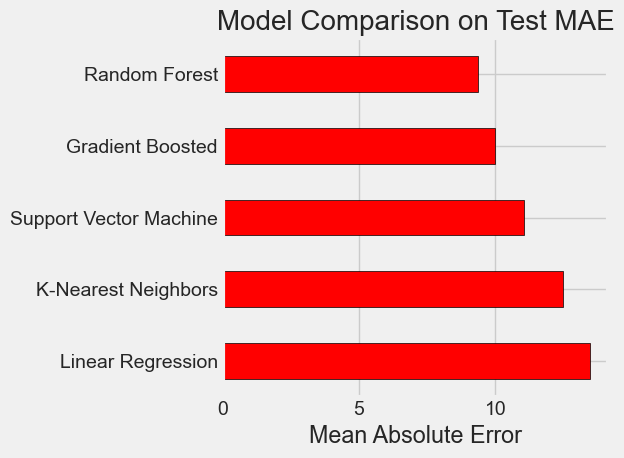

In [16]:
# Set plot style
plt.style.use('fivethirtyeight')

# Set figure size properly
plt.figure(figsize=(8, 6))

# DataFrame to hold the results
model_comparison = pd.DataFrame({
    'model': ['Linear Regression', 'Support Vector Machine',
              'Random Forest', 'Gradient Boosted', 'K-Nearest Neighbors'],
    'mae': [lr_mae, svm_mae, random_forest_mae, gradient_boosted_mae, knn_mae]
})

# Horizontal bar chart of test MAE
model_comparison.sort_values('mae', ascending=False).plot(
    x='model', y='mae', kind='barh', color='red', edgecolor='black', legend=False
)

# Plot formatting
plt.ylabel('')
plt.yticks(size=14)
plt.xlabel('Mean Absolute Error')
plt.xticks(size=14)
plt.title('Model Comparison on Test MAE', size=20)
plt.tight_layout()
plt.show()

From these results, we can conclude that machine learning is applicable because all the models significantly outperform the baseline

# Model Optimization  

## Hyperparameter Tuning with Random Search and Cross Validation

Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance. 

In [17]:
# Valid loss functions
loss = ['squared_error', 'absolute_error', 'huber']  # 'quantile' is also valid if needed

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['sqrt', 'log2', None]  # 'auto' is deprecated, use None instead

# Final fixed grid
hyperparameter_grid = {
    'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features
}


In the code below, we create the Randomized Search Object passing in the following parameters:

* `estimator`: the model
* `param_distributions`: the distribution of parameters we defined
* `cv` the number of folds to use for k-fold cross validation
* `n_iter`: the number of different combinations to try
* `scoring`: which metric to use when evaluating candidates
* `n_jobs`: number of cores to run in parallel (-1 will use all available)
* `verbose`: how much information to display (1 displays a limited amount) 
* `return_train_score`: return the training score for each cross-validation fold
* `random_state`: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one. 

In [18]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=25,
    scoring='neg_mean_absolute_error',
    n_jobs=-1, verbose=1,
    return_train_score=True,
    random_state=42
)

random_cv.fit(X, y)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['squared_error',
                                                 'absolute_error', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [19]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
11,35.904411,0.163464,0.020754,0.000432,500,6,8,None,5,absolute_error,"{'n_estimators': 500, 'min_samples_split': 6, ...",-8.889541,-8.781125,-8.943552,-9.380620,-8.998709,0.228122,1,-7.277711,-7.288188,-7.256899,-7.172518,-7.248829,0.045475
0,6.826770,0.033608,0.008029,0.000501,100,2,6,None,5,squared_error,"{'n_estimators': 100, 'min_samples_split': 2, ...",-9.118723,-9.091954,-8.953526,-9.306455,-9.117664,0.125743,2,-7.638187,-7.663474,-7.689039,-7.457408,-7.612027,0.091062
7,306.779097,1.586942,0.134474,0.002441,1500,10,1,None,15,absolute_error,"{'n_estimators': 1500, 'min_samples_split': 10...",-9.249191,-9.170297,-9.093870,-9.463114,-9.244118,0.137849,3,-1.196083,-1.202241,-1.135278,-1.142611,-1.169053,0.030298
15,131.820764,1.584517,0.077178,0.001631,900,10,1,None,10,huber,"{'n_estimators': 900, 'min_samples_split': 10,...",-9.084947,-9.207900,-9.155393,-9.539306,-9.246886,0.174374,4,-0.148516,-0.167615,-0.144663,-0.153969,-0.153691,0.008692
16,248.386464,4.490265,0.135180,0.005659,1500,2,1,None,15,absolute_error,"{'n_estimators': 1500, 'min_samples_split': 2,...",-9.195670,-9.122093,-9.165180,-9.588523,-9.267866,0.186968,5,-0.861135,-1.026647,-0.791732,-0.883330,-0.890711,0.085447
13,173.559506,0.545376,0.130082,0.002635,1500,2,8,None,10,squared_error,"{'n_estimators': 1500, 'min_samples_split': 2,...",-9.226688,-9.246239,-9.107644,-9.590705,-9.292819,0.179978,6,-0.011288,-0.013477,-0.014870,-0.014132,-0.013442,0.001338
1,14.786356,0.568263,0.038963,0.000218,900,6,6,log2,5,huber,"{'n_estimators': 900, 'min_samples_split': 6, ...",-9.287246,-9.178538,-9.085412,-9.623563,-9.293690,0.203407,7,-5.496137,-5.588254,-5.576057,-5.403166,-5.515904,0.074083
20,40.641064,0.275879,0.024755,0.000830,900,4,4,None,3,absolute_error,"{'n_estimators': 900, 'min_samples_split': 4, ...",-9.337440,-9.170642,-9.069811,-9.786704,-9.341149,0.274422,8,-8.535602,-8.360330,-8.151494,-8.378572,-8.356499,0.136571
5,15.133859,0.308091,0.042766,0.000440,1500,2,4,log2,3,huber,"{'n_estimators': 1500, 'min_samples_split': 2,...",-9.602836,-9.276169,-9.168757,-9.736725,-9.446121,0.231746,9,-7.094887,-7.140885,-7.102489,-6.902340,-7.060150,0.092765
10,11.856234,0.132935,0.064264,0.000831,1500,4,6,log2,5,squared_error,"{'n_estimators': 1500, 'min_samples_split': 4,...",-9.421560,-9.317151,-9.343412,-9.703872,-9.446498,0.153477,10,-4.219345,-4.247452,-4.252263,-4.121561,-4.210155,0.052672


In [20]:
print(random_cv.best_estimator_)

GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                          min_samples_leaf=8, min_samples_split=6,
                          n_estimators=500, random_state=42)


Here we will use grid search with a grid that only has the `n_estimators` hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [21]:
# Define the range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

# Define the model with correct loss function
model = GradientBoostingRegressor(loss='absolute_error',  # ← fixed here
                                  max_depth=5,
                                  min_samples_leaf=6,
                                  min_samples_split=6,
                                  max_features=None,
                                  random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=model,
                           param_grid=trees_grid,
                           cv=4,
                           scoring='neg_mean_absolute_error',
                           verbose=1,
                           n_jobs=-1,
                           return_train_score=True)

# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 max_depth=5,
                                                 min_samples_leaf=6,
                                                 min_samples_split=6,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [22]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

In [23]:
results.sort_values('mean_test_score', ascending = False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
14,43.287282,0.291520,0.020243,0.000027,800,{'n_estimators': 800},-8.819669,-8.879123,-8.834182,-9.298346,-8.957830,0.197815,1,-6.940059,-7.149118,-7.175793,-6.988979,-7.063487,0.100910
13,45.478837,0.119715,0.020233,0.000054,750,{'n_estimators': 750},-8.820788,-8.880412,-8.853534,-9.302863,-8.964399,0.196550,2,-6.970862,-7.177744,-7.247768,-7.021224,-7.104399,0.112566
12,46.399048,0.457334,0.021632,0.001676,700,{'n_estimators': 700},-8.821189,-8.885806,-8.853220,-9.307610,-8.966956,0.197999,3,-7.004452,-7.208211,-7.293800,-7.092431,-7.149723,0.110188
11,45.930842,0.307865,0.022400,0.004699,650,{'n_estimators': 650},-8.824889,-8.891454,-8.859486,-9.325032,-8.975215,0.203334,4,-7.040364,-7.271036,-7.325235,-7.151648,-7.197071,0.110133
10,42.677719,0.434634,0.022410,0.003637,600,{'n_estimators': 600},-8.829500,-8.899905,-8.872208,-9.313901,-8.978879,0.195045,5,-7.063402,-7.315200,-7.371834,-7.198747,-7.237296,0.118210


From this plot, it's pretty clear that our model is overfitting The training error is significantly lower than the testing error, which shows that the model is learning the training data very well but then is not able to generalize to the test data as well.

Based on the cross validation results, the best model using 800 trees and achieves a cross validation error under 9. This indicates that the average cross-validation estimate of the Energy Star Score is within 9 points of the true answer.

# Evaluate Final Model on the Test Set

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set. 

In [24]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(loss='absolute_error', max_depth=5,
                          min_samples_leaf=6, min_samples_split=6,
                          n_estimators=800, random_state=42)

In [25]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

2.99 s ± 11.1 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [26]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

40.9 s ± 138 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [27]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 9.9947.
Final model performance on the test set:   MAE = 8.9405.


The final model does out-perform the baseline model by about 10%, but at the cost of significantly increased running time. 
Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision of which model to use depends on the situation.
To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set. 

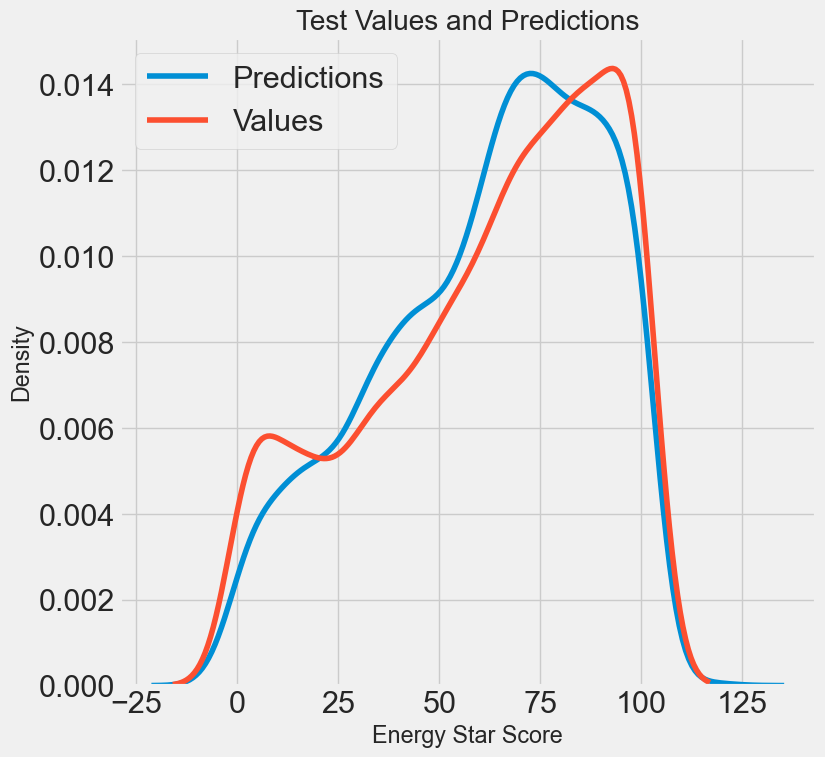

In [32]:
plt.figure(figsize(8, 8))

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');
plt.legend()
plt.show()

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median. 

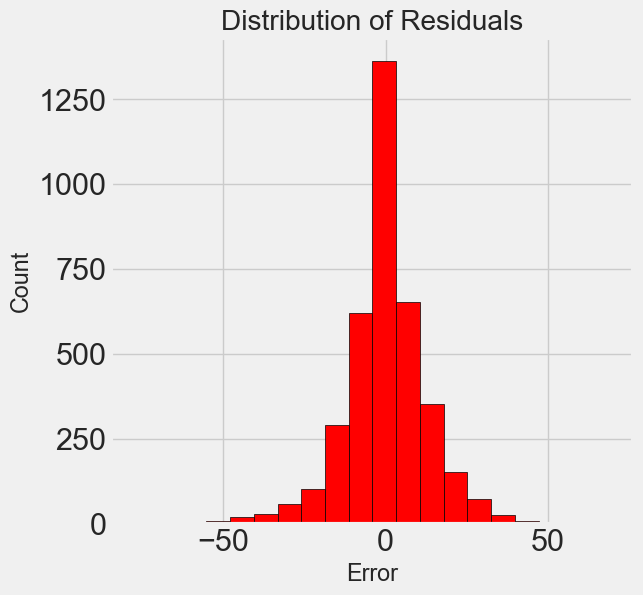

In [33]:
# Set figure size properly
plt.figure(figsize=(6, 6))

# Calculate the residuals
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color='red', bins=20, edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')

plt.show()

The residuals are close to normally disributed, with a few noticeable outliers on the low end. These indicate errors where the model estimate was far below that of the true value. 

# Conclusions

In this notebook, we covered crucial concepts in the machine learning pipeline:

* Imputing missing values
* Evaluating and comparing several machine learning methods
* Hyperparameter tuning a machine learning model using random search and cross validation
* Evaluating the best model on the testing set

The results showed us that machine learning is applicable to our problem, with the final model able to the predict the Energy Star Score of a building to within 9.0 points. We also saw that hyperparamter tuning was able to improve the performance of the model although at a considerable cost in terms of time invested.